# Deconstruction with Explicit Embeddings

In my post [Beyond Binary](http://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html), I showed how easy it is to create trainable "one-hot" neurons with the straight-through estimator. My motivation for this will be made clear in this post, in which I demonstrate the potential of explicit embeddings. In short, explicit embeddings allow for explicit deconstruction of inherently fuzzy data, which allows us to apply explicit reasoning and algorithms over the data, and communicate fuzzy ideas with concrete symbols. Using discrete embeddings, we can (1) create a language model over the embeddings, which immediately gives us access to RNN-based generation of internal embeddings (and sequences thereof), and (2) index sub-parts of the embeddings, instead of entire embedding vectors, which gives us (i.e., our agents) access to search techniques that go beyond cosine similarity, such as phrase search and search using lightweight structure.

The ultimate task we will tackle in this post is as follows:

Suppose we arranged the MNIST training images in a sequence. Does it contain any subsequences of three consecutive digits that have the following three features, respectively, and if so, where:

<img src='images/feature_query.png' />

The proposed solution presented does not use labels, and does not involve any vectors representing sequences of digits such as RNN states. Instead, we will make use of an inverted index over the symbolic language that explicit embeddings provide. The proposed solution is not perfect, and reveals the general challenge that we will face in our quest to enable AIs to represent fuzzy concepts with explicit symbols. It will be interesting to see if the approach presented can be improved to the point where it becomes practical to use as a general technique.

#### Human language and Stage III architectures

A comparison to human language is apt: although our thoughts are generally fuzzy and fraught with ambiguities (like real-valued embeddings (e.g., consider how many reasonable sequences could be decoded from the dense vector representation of a sequence in a sequence autoencoder)), much of our communication is explicit (of course, there is also body language, intonation, etc., which might be considered as real-valued, fuzzy communication channels).

If we think about the future of AI, I think this comparison is doubly important. In my mind, to date, there have been two major paradigms in AI: 

- **Stage I: Traditional AI based on explicit programming**: In the 20th century, many advances in AI were based explicit algorithms and data structures, such as [A\* search](https://en.wikipedia.org/wiki/A*_search_algorithm), [frames](https://en.wikipedia.org/wiki/Frame_(artificial_intelligence)), [case-based reasoning](https://en.wikipedia.org/wiki/Case-based_reasoning), etc.. A representative computer program based primarily on traditional AI was IBM's [Deep Blue](https://en.wikipedia.org/wiki/Deep_Blue_(chess_computer)). 

- **Stage II: Machine learning based on implicit programming**: More recently, the advances in AI have been primarily based on data, which is used to implicitly program the computer. We tell the computer what we want it to do by defining objectives and rewards, providing it with a general learning algorithm, and feeding it data. It learns on its own how to accomplish those ends: the means are never made explicit. A representative computer program based primarily on machine learning is DeepMind's [AlphaGo](https://en.wikipedia.org/wiki/AlphaGo).

Inevitably, I see the third major paradigm of AI to be the following hybrid:

- **Stage III: Implicit programming via explicit symbols, AKA programming via natural language**: As a prerequisite to strong AI, our computers will need to be able to communicate with humans via a higher-order interface like natural language. If such an interface becomes strong enough, and computers are given sufficient dominion over their internal functionality, we can teach them by talking to them. This requires that the computer be able to represent fuzzy concepts using explicit symbols. A representative (fictional) computer program that employed this approach is Iron Man's [J.A.R.V.I.S.](https://en.wikipedia.org/wiki/Edwin_Jarvis).

One very cool example of an architecture exhibiting stage III abilities is the VAE-GAN, presented in [Larsen et al. (2016)](http://www.jmlr.org/proceedings/papers/v48/larsen16.html). The VAE-GAN is able to generate new images and modify old images according to high-order discrete features. Here is the impressive Figure 6 from Larsen et al. (2016):

<img src='images/vaeganfigure6.png' />

You can see how given certain discrete features (Bald, Bangs, Black Hair, etc.), the VAE-GAN can modify the input image so as to include those features. In the same way, it can also generate new samples. This is a human-like ability that falls squarely within Stage III. 

This ability is similar in function to, but (per my current understanding) quite different in implementation from, the generative method we explore below. Because I've read next to nothing about GANs, I won't be able to give good commentary in this post. Nevertheless, I think the similarities are strong enough to merit an in-depth analysis. Indeed, a quick scan shows that certain VAE and GAN architectures have already adopted a form of explicit embeddings (e.g., [this paper (InfoGAN)](https://arxiv.org/abs/1606.03657) and [this paper (Discrete VAE)](https://arxiv.org/abs/1609.02200), but I haven't had a chance to actually read any of these papers yet. I'm not sure how similar/different they are from what I present in this post, and I plan to report back on VAEs/GANs and other architectures after I've gotten my hands dirty with them.^[If this is something you're interested in exploring yourself, my planned starting point is this [post](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/) by [hardmaru](https://github.com/hardmaru) (and the underlying [implementation](https://github.com/hardmaru/cppn-gan-vae-tensorflow)), which uses a Tensorflow-based VAE-GAN to turn MNIST into something quite beautiful.]

Because I only discuss discrete embeddings below, I wanted to emphasize here the dual nature of discrete and real embeddings. Certainly a discrete symbol can be embedded in real space (see, e.g., word2vec). In this post, we are specifically concerned with embedding real vectors in discrete space (maybe I should have titled this post "vec2word"). Each approach has its own advantanges. For example, it is far more difficult to capture continuous features like width, height, weight, angle, etc. with discrete features. There is nothing stopping us from creating models that have both real and discrete internal embeddings (either as a mixed embedding, or as separate/interchangeable _dual_ embeddings). In fact, we can keep all of our models that use real embeddings exactly the way they are, and add an internal discrete dual of the real embeddings via a discrete autoencoder (a la Part I of this post)---this alone will give us access to the capabilities demonstrated in this post. 

With that said, let's dive in. The ideas in this post are a long ways away from taking us all the way to Stage III, but I think they're a step in the right direction. We proceed as follows:

- First, we'll build a dead simple MNIST autoencoder with an explicit hidden layer and demonstrate that explicit embeddings are sufficiently expressive to achieve good performance. We'll then visualize the embeddings to get a sense of what each neuron represents.

- Then, we'll show how we can create an RNN-based generative model of MNIST, and demonstrate a few cool things that it can do, including generating samples based on a prototype (i.e., generate "more like this") and generating samples based on specific feature.

- Finally, we'll show how we can apply traditional information retrieval (IR)---which falls squarely within the Stage I paradigm---to do _post-classification_ over the features of a Stage II model, and in particular, over sequences of such features.

Throughout our journey, we will repeatedly come face-to-face with the following general challenge:

- In order to represent certain fuzzy ideas with explicit codes (words), we need a lot of explicit codes (words). But what happens if the fuzzy ideas are larger than a single word? Then we need to compose words. But no matter how we compose words, we have a line-drawing problem: what is included inside the fuzzy concept, and what is not?

This challenge is inherent to language in general, and is one of the fundamental problems of the legal domain. If it had an easy solution, legalese would not exist, judicial dockets would not be so full, and policy drafting would be a whole lot easier. I will refer to this problem throughout as the problem of **explicit definition**.

## Part I: An autocoder with explicit embeddings

The purpose of this part is to (1) prepare us for parts II and III, and (2) to give us some intuitions about how discrete embeddings might represent real-valued embeddings, but also (3) to show that real embeddings and discrete embeddings can effectively be interchanged (we can encode one into the other and back), and can therefore co-exist within the same model. This means that everything we do in Parts II and III can be applied to any layer of a real-valued model by discretely autoencoding that layer.

#### Imports and helper functions

In [1]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
from deconstruction import * # AVAILABLE HERE[!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### Autoencoder architecture

The architecture of our autoencoder is very simple. We use a single convolutional layer with 16 5x5 filters, followed by a 2x2 max pooling layer. Then there is the fully-connected (FC) embedding layer, which consists of either explicit (one-hot) neurons, real neurons, or both. The embedding layer is then projected back into the original input space using a fully-connected projection followed by a sigmoid. 

For our explicit autoencoder, we use 80 explicit neurons, each with 8 dimensions. We also enforce, via training, that the first dimension of each neuron is dead by requiring the network to project all 0s when the explicit neurons are all hot in the first dimension (this will be useful for certain visualizations).

To recap, the layers used are:

1. Input
2. 5x5 Conv (16 dims)
3. FC with 8-dimensional one-hot activation (80 neurons, 640 binary dimensions), dead in the first dimension
4. FC softmax projection

We train the network with simple gradient descent with a batch size of 50 and a learning rate of 1e-1, after an initial "warm-up" epoch that uses a learning rate of 1e-4 (so that the one-hot neurons learn to fire more predictably). 

**Important note on mixed embeddings**: In case you try this at home with a mix of real and explicit neurons (within the same layer), beware that the explicit neurons are noisy during training. This will cause the model to put its faith in the real neurons (which fire deterministically), and will cause the most important information to be stored in the real neurons. If training a mixed model, it is advised that you either apply heavy noise to the real neurons (e.g., via dropout or gaussian noise) or pretrain the explicit neurons to capture as much information as they can, and then train the real neurons afterwards so that they finetune the explicit neurons (because it makes much more sense, at least to me, to finetune explicit chunks with real values, than vice versa).

In [2]:
g = build_classifier(onehot_dims = 8, explicit_neurons = 80)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Uncomment to run training, or use the below checkpoint to load
# tr, va = train_autoencoder(g, sess, num_epochs=30)

saver = tf.train.Saver()
saver.restore(sess, './ckpts/trained_80x8_autoencoder')

#### Autoencoder results

Training for 30 epochs gets us to a loss between 5.5 and 6.0 on the validation set, and with some more training, we can get the loss down to 5.0. By comparison if we train the same architecture using 80 real neurons, we can easily achieve losses under 4.0. Nevertheless, while our 8-dimensional (really 7, because of the dead dimension) one-hot neurons are less expressive, they still have a lot of power: $7^{80}$ possible combinations is a big number. A visual comparison of inputs and projections on the first 12 images of the MNIST test set is shown below.

##### Original MNIST (top) vs projections (bottom)

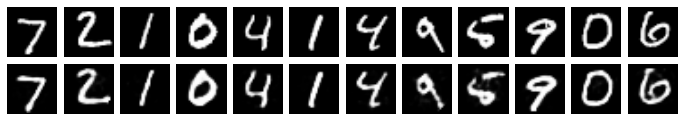

In [3]:
projs = sess.run(g['projection'], feed_dict={g['x']: mnist.test.images[:12], g['stochastic']: False})
plot_2xn(12,np.concatenate((mnist.test.images[:12], projs)))

As you can see, our projections of the first 12 MNIST test images are only slightly corrupted. The major features of the original images remain, with a few faded portions.

#### Visualizing features

Given that our features are explicit, we can visualize each one precisely. Let's have a go at it, by setting all neurons in the "off" position (first dimension), except for one, chosen at random. You can view the results below for 24 random samples that have a single random feature of a single random neuron turned on.

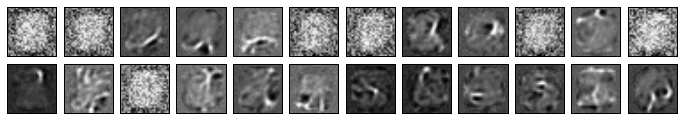

In [3]:
emb_feed = np.tile(np.array([[[1,0,0,0,0,0,0,0]]]), (24, 80, 1))
for i in range(24):
    emb_feed[i][i%80] = np.eye(8)[np.random.randint(1,8)]
projs = sess.run(g['projection'], feed_dict={g['embedding']: emb_feed, g['stochastic']: False})
plot_2xn(12,projs)

Notice how several of the features are pure noise. This is because some neurons have activations that never fire: despite being able to fire in 7 different live positions, some neurons fire only in a subset of those 7. Let's see the firing densities of the first 5 neurons on the MNIST validation set:

In [4]:
embs = sess.run(g['embedding'], feed_dict={g['x']: mnist.validation.images, g['stochastic']: False})
densities = np.sum(embs, axis=0) / np.sum(np.sum(embs, axis=0), axis = 1, keepdims=True)
for i in range(5):
    print("{:.2f} - {:.2f} - {:.2f} - {:.2f} - {:.2f} - {:.2f} - {:.2f} - {:.2f}".format(*densities[i]))

0.00 - 0.16 - 0.21 - 0.17 - 0.16 - 0.18 - 0.00 - 0.12
0.00 - 0.00 - 0.14 - 0.18 - 0.18 - 0.17 - 0.19 - 0.14
0.00 - 0.22 - 0.19 - 0.15 - 0.16 - 0.15 - 0.00 - 0.13
0.00 - 0.26 - 0.20 - 0.00 - 0.23 - 0.12 - 0.07 - 0.11
0.00 - 0.09 - 0.00 - 0.22 - 0.29 - 0.10 - 0.12 - 0.18


Because we trained our network to consider the first dimension as dead, it never fires. Additionally, we see that the network has learned a few more dead dimensions: the first and third neurons never fire in the 7th position, the second neuron never fires in the 2nd position, the fourth neuron never fires in the 4th position, and the last neuron never fires in the 3rd position. 

These positions correspond to the "noisy" items in the grid above. If we only plot live features according to the densities we just computed, we eliminate the noisy features:

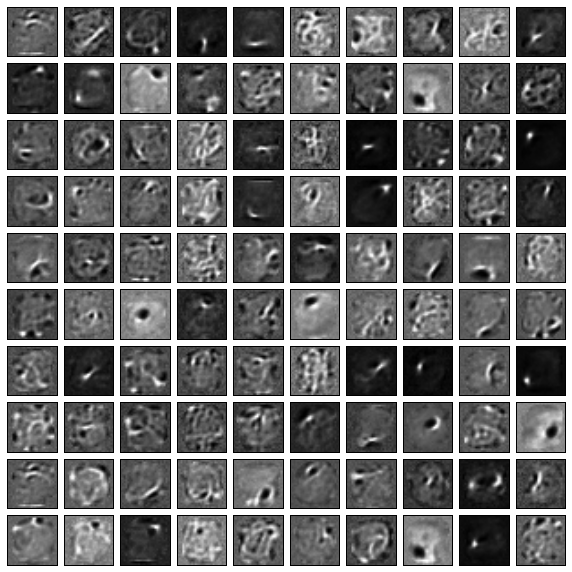

In [5]:
emb_feed = np.tile(np.array([[[1,0,0,0,0,0,0,0]]]), (100, 80, 1))
for i in range(100):
    emb_feed[i][i%80] = np.eye(8)[np.random.choice([0,1,2,3,4,5,6,7], p=densities[i%80])]
projs = sess.run(g['projection'], feed_dict={g['embedding']: emb_feed, g['stochastic']: False})
plot_nxn(10,projs)

Pretty cool. There seems to be a fairly even distribution between sharp positive features, negative hole features (the ones that look like black holes), and somewhat random features. Note that these features are all very faint individually (the function that plots the images is automatically normalizing the white level), and they only become sharp once you add many of them together.

In fact, let's do that now. If we ignore the fact that neurons are dependent (there is a complex joint probability distribution), we can sample them according to their raw densities:

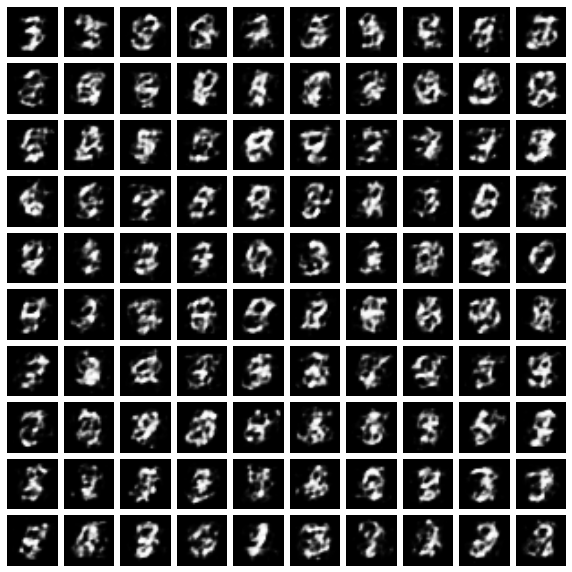

In [6]:
emb_feed = np.tile(np.array([[[1,0,0,0,0,0,0,0]]]), (100, 80, 1))
for i in range(100):
    for j in range(80):
        emb_feed[i][j] = np.eye(8)[np.random.choice([0,1,2,3,4,5,6,7], p=densities[j])]
        
projs = sess.run(g['projection'], feed_dict={g['embedding']: emb_feed, g['stochastic']: False})
plot_nxn(10,projs)

This generates some pretty cool looking designs that look more like murky shadows of numbers than numbers themselves. 

Note that despite the almost random appearance of these designs, they can each be precisely communicated in a sparse binary code consisting of exactly 560 zeros and 80 ones.

## Part II: Generating digits with an RNN

Our neurons are explicit, and so we can think of each neuron as a word in a language, where each MNIST digit is made up of 80 different words. Modeling the joint distribution then, is very much like modeling a language, which is an area in which RNNs shine. In this section we create an RNN-based generator that models the joint distribution of the explicit MNIST embeddings. 

#### Data

We want to feed our RNN sequences of 80 neurons, but our neurons have no predetermined order (query how to give them a heirarchical structure, which would greatly expand their usefulness). Thus, in order to allow the RNN to generate the remainder of an embedding given arbitrary neurons, we randomize the order in which the neurons are presented to the RNN during training. This forces us to use 640-dimensional one-hot vectors for our model inputs and targets (using 8-dimensional vectors would pre-suppose an order).

To illustrate precisely what our training sequences look like, below is our data generator, and two different training sequences generated by the first image in the MNIST training set (note how they just permutations of each other). Each index indicates where the flattened embedding layer is "hot". 

In [3]:
def imgs_to_indices(imgs):
    embs = sess.run(g['embedding'], feed_dict={g['x']: imgs, g['stochastic']: False}) #[n, 80, 8]
    idx = np.argmax(embs, axis=2) #[n, 80]
    res = []
    for img in range(len(imgs)):
        neuron_perm = np.random.permutation(list(range(80))) #order of neurons we will present
        res.append(idx[img][neuron_perm] + neuron_perm * 8)
    return np.array(res)

def gen_random_neuron_batch(n):
    x, _ = mnist.train.next_batch(n) # [n, 784]
    res = imgs_to_indices(x)
    return res[:,:-1], res[:,1:]

In [4]:
for i in range(2):
    print(imgs_to_indices(mnist.train.images[:1]))

[[ 18 167 116 546 122 180 236 145 563  13 101 249 575 446 475 347  73 194
  583 283 131 354 393 523 204 365 339 469  54 259 187   3 625  37 223 228
   47 457 489 419 242 175  83 385 383 110 518 141 484 589 412 157 305 500
  613 543 291 210  70  90 313 433 594 634 509 299 426  28 404 617 372  58
  329 273 603 325 265 557 451 531]]
[[404  70 339 634 236 223 433 419 329  90  13 583 157 457 110 116 543  37
  523  54  28  83 500 575 283 180 141 451 594 325 347 475 204 393   3 365
  175 291 265 518 259 531 167 228 299 354 305 589 372 187  58 446 625 210
  563 557 249 426 412 101 613 489 469 313  47 617 385 131 242 509 484  18
  603 194  73 122 145 383 273 546]]


#### Model

The architecture of our RNN is very simple. We use a 1000-unit GRU cell, with a 100-dimensional (real-valued) embedding layer. The network is trained for 10 epochs with Adam at an initial learning rate 2e-3. As the number of possible input sequences is practically limitless (each of the 55000 training examples can generate 80! permuted sequences), no regularization is used. The norm of the gradient is clipped at 1.0. I did not do a hyperparameter search, or even early stopping, so this is likely far from an optimal generator.

In [5]:
h = build_recurrent_generator()
sess.run(tf.variables_initializer([v for v in tf.global_variables() if 'generator' in v.name]))

# Uncomment to run training, or use the below checkpoint to load
# train_RNN(h, sess, batch_generator=gen_random_neuron_batch, epochs=10)

saver = tf.train.Saver()
saver.restore(sess, './ckpts/gen_80x8_1000state_RANDOMPERM_10epochs_')

#### Generation

After some helper functions:

In [6]:
def gen_next_step(current_input, prior_state=None):
    """Accepts a current input (index) (shape (batch_size, 1)) and a prior_state 
    (shape (batch_size, 1000)). Returns dist over the next step, and the resulting state."""
    if prior_state is None:
        feed_dict={h['x']: current_input}
    else:
        feed_dict={h['x']: current_input, h['init_state']: prior_state}
    return sess.run([h['next_y_dist'], h['final_state']], feed_dict=feed_dict)

In [7]:
def generate_embedding(prompt=np.array([2]), top_choices = 1):
    """ Accepts a prompt, and generates the rest"""
    state = None
    
    while len(prompt) < 80:
        if state is not None:
            y_dist, state = gen_next_step(np.expand_dims([prompt[-1]], 0), state)
        else:
            y_dist, state = gen_next_step(np.expand_dims(prompt, 0))
            
        p = y_dist[0]
        p[np.argsort(p)[:-top_choices]] = 0
        p = p / np.sum(p)
        next_idx = np.random.choice(640, p=p)
         
        prompt = np.concatenate((prompt, [next_idx]))
    
    return prompt

In [8]:
def emb_idx_to_emb(emb_idx):
    emb = np.eye(8)[np.array(sorted(emb_idx)) % 8]
    return np.reshape(emb, (1, 80, 8))

We can now generate some digits. Below, we sample 12 random images from the MNIST validation set, transform them into their neuron indices, randomly permute the indices, and take the first n-indices (for n in {5, 10, 20, 40}) as the prompt to our RNN. The RNN generates the rest, which we convert back into 80x8 embeddings, feed into our decoder, and plot. The top rows of each figure are the orginal digits, and the bottom rows are the digits generated from using their neuron activations as prompts.

In [13]:
def generate_from_originals(size_of_prompt):
    originals, generated = [], []
    for i in range(12):
        img_idx = np.random.randint(0, 5000)
        originals.append(mnist.validation.images[img_idx:img_idx+1])
    for i in range(12):
        img = imgs_to_indices(originals[i])
        emb_idx = generate_embedding(img[0][:size_of_prompt], 3)
        emb = emb_idx_to_emb(emb_idx)
        generated.append(emb)
    originals, generated = np.squeeze(originals), np.squeeze(generated)
    projs = sess.run(g['projection'], feed_dict={g['embedding']: generated, g['stochastic']: False})
    plot_2xn(12, np.concatenate((originals, projs)))

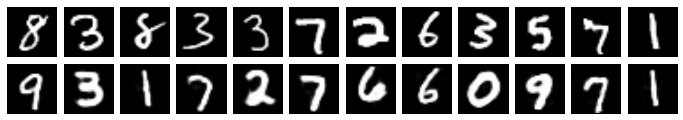

In [16]:
generate_from_originals(size_of_prompt=5)

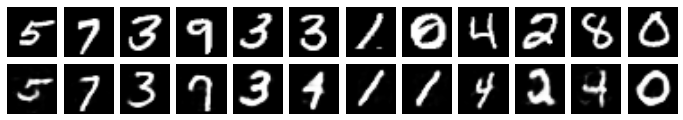

In [15]:
generate_from_originals(size_of_prompt=10)

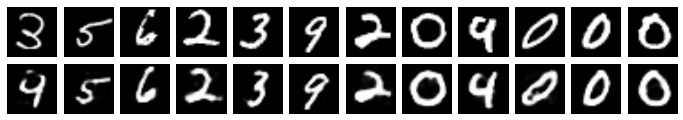

In [16]:
generate_from_originals(size_of_prompt=20)

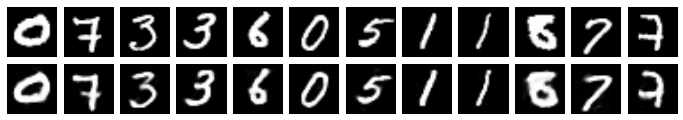

In [17]:
generate_from_originals(size_of_prompt=40)

From the above, we can see how important each neuron is. With only a 5 neuron prompt, our generator is about 50/50 to generate the same digit vs another digit (again, originals are on the top row, and generated digits are on the bottom). When it generates the same digit, it varies quite a bit from the original. As we ramp up the prompt to 40 neurons from the original, our generator starts to generate samples that look more and more like the original.

#### Generated samples vs. the prompts used to generate them

To get an idea of how the prompt conditions the model, we plot some samples (top) against the prompts they were generated from (bottom). All come from the same random image, and the prompt sizes from left to right start are [1, 5, 9 ... 37]. 

In [54]:
res, prompts = [], []
img_idx = np.random.randint(0, 5000)
img = imgs_to_indices(mnist.validation.images[img_idx:img_idx+1])[0]
for i in range(10):
    prompts.append(np.random.permutation(img))
    emb_idx = generate_embedding(prompts[-1][:(4*i)+1],3)
    emb = emb_idx_to_emb(emb_idx)
    res.append(emb)
for i in range(10):
    set_neurons = set(prompts[i][:(4*i)+1] // 8)
    neurons_indices = np.array([8*j for j in range(80) if j not in set_neurons])
    emb = emb_idx_to_emb(np.concatenate((prompts[i][:(4*i)+1],neurons_indices)))
    res.append(emb)
res = np.squeeze(res)

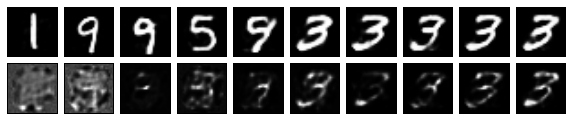

In [55]:
projs = sess.run(g['projection'], feed_dict={g['embedding']: res, g['stochastic']: False})
plot_2xn(10, projs)

#### Generating by prototype: "more like this" samples

Below, we use a prompt of 30 neurons to generate "more like this" of a rather distinctive 7 from the mnist test set. As demonstrated above, we could make our generated samples more similar or less similar by varying the length of our prompt. Note how our generator sometimes generates 9 instead of 7. 

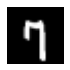

In [56]:
plot_nxn(1, mnist.test.images[80:81])

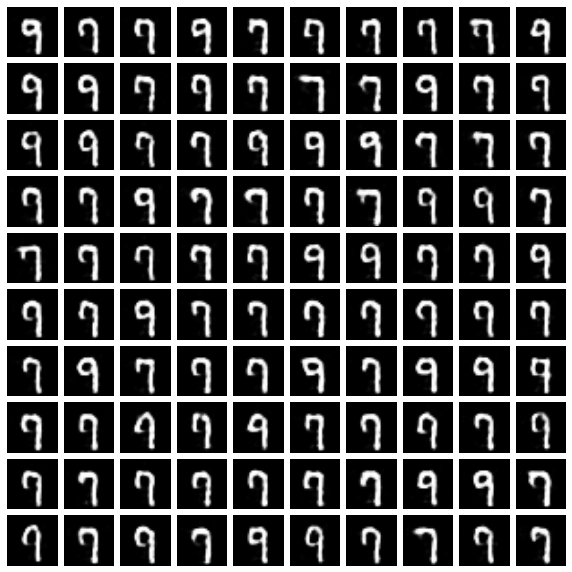

In [29]:
res = []
for i in range(0, 100):
    img_idx = np.random.randint(0, 5000)
    img = imgs_to_indices(mnist.test.images[80:81])
    emb_idx = generate_embedding(img[0][:30], 2)
    emb = emb_idx_to_emb(emb_idx)
    res.append(emb)
res = np.squeeze(res)
projs = sess.run(g['projection'], feed_dict={g['embedding']: res, g['stochastic']: False})
plot_nxn(10, projs)

#### Generating samples with distinct features

Now let's do something really cool. We'll draw eight of our own small features, find out which explicit dimensions they correspond to, and then use those dimensions as prompts to generate samples that have that feature.

Here, we run up against the general challenge of explicit definition for the first time. While we can draw the features, and see the features, when does an MNIST digit have that feature? Given that reasonable people can disagree on the answer, it is unreasonable for us to try expect a single explicit feature specification (in our case, a prompt) to be perfect. Nevertheless, we need to provide our RNN with a prompt in order for it to generate samples. 

The method we use below is more than a little brittle, and takes a bit of trial and error to get right. To find the embeddings that each feature corresponds to we add random noise the image of the feature, and run a batch of the noisy images through our encoder. We then construct our prompts by subsampling the activations that fire often for that feature. 

Based on trial and error, I defined "fire often" to mean firing in more than 5/6 of all noisy samples, and chose to subsample 60% of the activations for each prompt. Obviously, this is not a practical approach for the general case, and additional work will need to be done in order to find something that generalizes well to other cases.

In [57]:
import matplotlib.image as mpimg

In [58]:
features = []
for i in range(8):
    features.append(np.reshape(1. - mpimg.imread('./images/feature_{}.png'.format(i), format='grayscale')[:,:,0] / 255., (1,784)))
features = np.array(features)
features *= 1.5

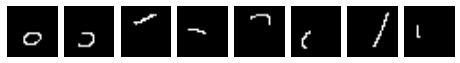

In [59]:
plot_mxn(1, 8, features)

In [60]:
def get_noisy_imgs(feature):
    noisy_imgs = []
    for img in range(300):
        noisy_img = feature.copy()
        for i in range(784):
            while np.random.random() > 0.75:
                noisy_img[0, i] += min(0.2, 1-noisy_img[0, i])
        noisy_imgs.append(noisy_img)
    return np.squeeze(noisy_imgs)

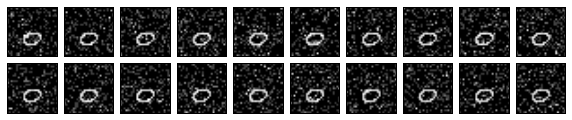

In [61]:
first_feature_with_noise = get_noisy_imgs(features[0])[:20]
plot_2xn(10, first_feature_with_noise)

Just for fun, below are the projections of the first feature. You can see that the autoencoder can't autoencode the noise properly, as it was trained on regular looking digits, but that the feature we asked for is present in all of them.

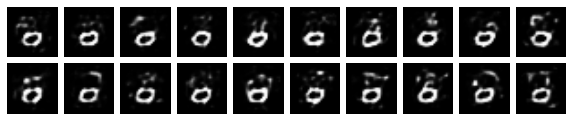

In [62]:
projs = sess.run(g['projection'], feed_dict={g['x']: first_feature_with_noise, g['stochastic']: False})
plot_2xn(10, projs[:20])

We generate noisy images for each feature, and collect the firing patterns:

In [63]:
firing_patterns = []
for feature in range(8):
    noisy_imgs = get_noisy_imgs(features[feature])
    embs = sess.run(g['embedding'], feed_dict={g['x']: noisy_imgs, g['stochastic']: False})
    firing_patterns.append(np.sum(embs, axis=0))

For reference, here are the firing patterns for the first three neurons of the first feature:

In [64]:
firing_patterns[0][:3]

array([[   0.,    0.,    6.,  141.,  130.,   10.,    0.,   13.],
       [   0.,    0.,    5.,    8.,  216.,   64.,    5.,    2.],
       [   0.,   52.,    0.,    1.,    1.,   87.,    0.,  159.]], dtype=float32)

As described above, we use those firing patterns to create prompts. We generate 7 samples for each feature:

In [67]:
generated_samples = [] 
for feature in range(8):
    num_common_activations = np.sum(firing_patterns[feature] > 250)
    prompt = np.array(list(range(640)))[np.argsort(np.reshape(firing_patterns[feature], 
                                                    (640)))[::-1][:num_common_activations]]
    nums = np.sort(np.reshape(firing_patterns[feature], (640)))[::-1][:num_common_activations]
    den = np.sum(nums)
    p = nums/den
    generated_samples.append([])
    for sample in range(0, 7):
        emb_idx = generate_embedding(np.random.choice(prompt, 
                            size=max(int(num_common_activations*.6), min(int(num_common_activations), 5)), 
                                                      replace=False, p=p), 2)
        emb = emb_idx_to_emb(emb_idx)
        generated_samples[-1].append(emb)
generated_samples = np.squeeze(generated_samples)
generated_samples = np.reshape(np.swapaxes(generated_samples, 0, 1), (56, 80, 8))

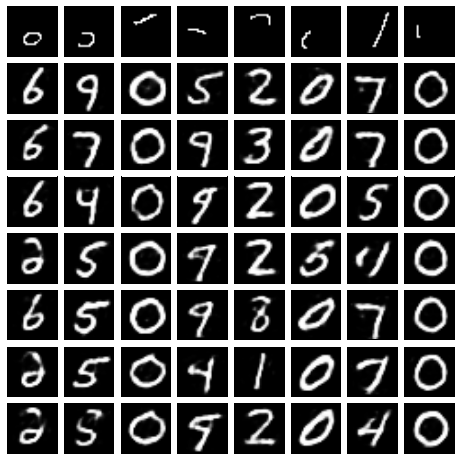

In [68]:
projs = sess.run(g['projection'], feed_dict={g['embedding']: generated_samples, g['stochastic']: False})
plot_nxn(8, np.concatenate((np.squeeze(features), projs)))

The original features are shown in the top row, and the samples generated based on that feature are shown below. 

Although most generated samples have the feature we wanted, many do not, and for some features, there is not much diversity in the samples (they seem to be biased towards a single digit, whereas multiple digits might contain the desired feature). We might consider a few techniques to improve the results:

- First, we can make the feature more fuzzy---instead of just adding noise, we can also randomly shift and scale it, so as to capture a more diverse set of neuron activations, and create more diverse samples. 
- Second, we might think that instead of sampling neuron activations, we can obtain the networks "confidence" in each neuron activation (e.g., the real number from the softmax activation, before it is turned into a one-hot vector); this might give a better sense of the importance of each neuron activation. 
- Third, we might take more care in designing our RNN generator (e.g., actually validate it's performance, and not just use our first random guess at a workable architecture/hyperparameters). 
- Finally, I note that our autoencoder could not be much simpler than it already is. If we had multiple convolutional and deconvolutional layers in both the encoding and decoding sections, I suspect that generated samples would contain the feature in much more abstract and diverse ways. 

Below, we'll see how we can take advantage of memory to create better prompt and improve the generation results.

## Part III: Structured information retrieval using explicit embeddings

Now we get to the most interesting part of our little journey. As we noted above, using explicit embeddings to represent data is very much like using a language, which means that everything we know and love above searching for language applies to searching for embeddings.

We proceed as follows:

1. We'll do a crash course on search, and comment on the relations between search, classification and generation. 

2. We'll take a look at the how the memory of the MemNN architecture uses a cosine distance-like measure to achieve impressive results. 

3. We'll take a look at the effectiveness of cosine distance-based retrieval of individual MNIST digits. This will help develop an intuition for why cosine distance-based retrieval is effective for MemNNs. We'll also see how we can use our memory to improve the feature-based generator we made above.

4. Finally, we'll get to the point: we'll look at the effectiveness (or lack thereof) of cosine distance-based retrieval over sequences of MNIST digits, and consider the challenges that sequences of memories pose for cosine distance-based retrieval. This is key, because an agent that cannot deal with sequences is a mere function approximator, not an intelligent actor. We'll show how retrieval over the explicit embedding space is able to effectively deal with sequences, where cosine distance-based retrieval fails. 

### A crash course on search

I recently had the pleasure of reading the textbook [Information Retrieval: Implementing and Evaluating Search Engines](http://www.ir.uwaterloo.ca/book/) by Stefan Büttcher, Charles L. A. Clarke, and Gordon V. Cormack, which this section is heavily based upon. This is a gem among textbooks, up there with great math books like Axler's Linear Algebra Done Right and Abbott's Understanding Analysis, and was my inspiration for thinking about discrete embeddings. It's not short, but it's a page turner, and I highly recommend it. 

To some extent, we all understand search, because we use it every day. A search engine takes some words (the _query_), and finds the documents that contain them. The key data structure used in search is the [_Inverted Index_](https://en.wikipedia.org/wiki/Inverted_index), which you can consider as a hash table that maps each word to its _postings_ list. The _postings_ of a word contain all the positions that the word appears in a document collection. For example, the postings for the word "deconstruction" might look something like this:

    "deconstruction": <document: 23, positions: 1, 55 ... 1554>, <document: 45, positions: 6, 8>, ... <document: 2442, positions: 52>
    
where each document, and each position within a document has been given a number. Postings are a _sorted_ list of those documents and positions. Because they are sorted, postings lists can be merged efficiently during query evaluation, so that we can iterate over the postings to find which documents in our collection contain multiple terms, or, if doing a phrase search, find those documents containing the phrase being searched. In addition to the postings list, most search engines also store some global information about the words and documents themselves, including:

- total documents indexed
- the length of each document
- the frequency of each word within a document (usually included in the postings list itself)
- number of documents in the collection

Using the above information, search engines can efficiently score each document in the collection according to some scoring function of the document and the query, and return the top results. Scoring functions often treat both the query and the document as a _bag of words_, which ignores proximity, order and other relationships between the terms (i.e., each term is treated as independent). Using the _bag of words_ assumption, we can model each query or document as a _term vector_ of length |V|, where |V| is the size of our vocabulary. Given the 5-term vocabulary, $\{t_1, t_2 ... t_5\}$, the document or query $\{t_1, t_2, t_1, t_4\}$ might have the vector $[2, 1, 0, 1, 0]$. Scoring functions in the bag of words paradigm can be expressed in the following form (equation 5.16 from Büttcher et al.):

$$\text{score}(q, d) = \text{quality}(d) + \sum_{t \in q}\text{score}(t, d)$$

where q, d, and t refer to a query, document, and term, respectively. An example of a quality function is Google's [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm. In our MNIST example, the quality of an example might be some measure of how characteristic of the dataset a digit is (e.g., how "clean" the digit is). This quality rating is independent of the query. The $\text{score}(t, d)$ function in the second term can usually be dissected into the following form:

$$\text{score}(t, d) = TF \cdot IDF$$

where TF is the _term frequency_ of t in document d, and IDF is t's _inverse document frequency_. Term frequency is a measure (function) of how often the query term appears in a document, and inverse document frequency is a measure of how frequent the term is across all documents. The IDF term appears because, intuitively, if a term is very common across all documents (low IDF), we don't want it to contribute a lot to the score. Vice versa if the term is very rare across all documents (high IDF)---we want it to contribute a lot to the score if it shows up in a document. IDF usually takes on a "standard form" (equation 2.13 of Büttcher et al.):

$$IDF = \log(N/N_t).$$

Let us take a moment to appreciate that summing TF-IDF scores is actually very similar to taking the cosine similarity of the query's term vector and document's term vector, given that each vector is adjusted appropriately. Starting with the vector consisting of the count of each term in the query, adjust it by multiplying each entry by the IDF for that term. Starting with the vector consisting of the count of each term in the document, adjust it by the length of the document (i.e., normalize the vector). If we now take their dot product and adjust by the query length, we obtain the cosine similarity between our IDF-adjusted query vector and the document vector. When ranking results, we don't care about the scores themselves, and only the order, and thus the final step of adjusting the dot product by the query length is unnecessary. Thus, _bag of words_ scoring models are closely related to cosine distance. Below, we'll do a visual demonstration of the effectiveness of cosine distance, and adjusted cosine distance (a la TF-IDF), for retrieving relevant memories.  

The above said, it is important to recognize that not all TF-IDF methods can be easily cast to cosine similarity: in particular, the TF component is usually taken as a function of the term frequency, rather than a simple count thereof, resulting in more complex search methods.

### Search vs classification, and the relationship between search and generation

Search and classification are closely related: whereas classification takes and instance and places it in a category, search takes a category and finds instances in that category. A key point to note here is that information needs during search can be incredibly diverse: whereas classification usually involves only a handful of relevant categories, the number of potential queries in a search is limitless. I like to think of search as `post-classification`: We define a category _ex-post_ (after the fact), and then find examples of that category that are stored in our memory.

If we think about the way humans search and classify, we note that classification usually occurs at the high levels of abstraction with little subtlety (categories in italics): 

- This is a _pen_.
- The sky is _blue_.
- Boy, was that [thing] _cool_!

On the contrary, when we search our memory (or generate hypotheticals and new ideas) the details become very important:

- That reminds of the time that X, Y, and Z happened, because of A, B, C. 
- We could differentiate our product by adding [some specific detail].

In order for our networks / agents to do the latter, we require them to operate and reason over individual _features_ or details. I call this _deconstruction_, in order to connect it to what humans do (this is related to, but different from, from the more mainstream ML concepts of _feature learning_ and _learned representations_). Humans are very good at calling out explicit details, and this is the point of this post: to give our networks explicit representations that they can operate over. 

Note that generation and memory are very closely related, in that their outcomes are often interchangeable. If we need to come up with an example of something, we often search our memories first, before trying to generate one. We can even go a step further, and say that all of our human memories are "generated", not remembered---consider what would happen if we overtrained the RNN in Part II above to the point where it "memorized the training set". If memory proves insufficient, or if our task requires creativity, then we can nevertheless leverage memories in order to improve generation (I demonstrate this below). 

Later, it will be useful to a specific example of external memory that is not MNIST, so let us now consider now the MemNN. We'll examine how its external memory works, and how it might be replaced by an external generator to accomplish similar ends.

### An Introduction to MemNNs

The MemNN, introduced by [Weston et al. (2014)](https://arxiv.org/abs/1410.3916) and expanded upon in [Weston et al. (2015)](https://arxiv.org/abs/1502.05698), is a very basic, memory-augmented neural network that has been proven effective on a variety of question-answering tasks. For our purposes, it will be sufficient to look specifically at the type of task it was used to solve, how the external memory module enabled this, and how we could extend its capabilities by using a memory-generation (mem-gen) module. Below is a description of the most basic MemNN presented in Weston et al. (2014) as it relates to the above---a full description of the architecture is presented in Weston et al. (2014), and improvements thereon, in Weston et al. (2015). 

An example of the basic QA task, and the MemNN's responses (in CAPS), is shown below (this is a reproduction of Figure 1 from Weston et al. (2014)):

    Joe went to the kitchen.
    Fred went to the kitchen.
    Joe picked up the milk.
    Joe travelled to the office.
    Joe left the milk.
    Joe went to the bathroom.
    
    Where is the milk now? 
        OFFICE
    Where is Joe? 
        BATHROOM
    Where was Joe before the office? 
        KITCHEN
    
Isn't that awesome? The MemNN is able to answer these questions by (1) retrieving relevant memories (_retrieval_), (2) using the retrieved memories together with the input to generate a response (_response_). 

Each memory of the MemNN is stored as a bag of words representation of a _sequence_ of text. In the above example, each sentence is such a sequence ("Joe went to the kitchen"). The bag of words representation is as described above in "A crash course on search": a sparse vector, with a 1 in the indices corresponding to "Joe", "went", "to", "the", and "kitchen". Weston et al. also provide a method for dealing with arbitrarily long sequences of text: they propose a "segmenter" to divide long sequences into smaller units (e.g., sentences), and then use the bag of words representations of those sub-sequences as inputs and memories. 

The inputs to the MemNN have the same bag of words representation. Memories are retrieved one-by-one, where earlier memories retrieved impact the search for later memories. A memory is retrieved based on the input (if it is a question) and any previously retrieved memories by:

1. Embedding the input into a real-valued vector, $x$.
2. Embedding any previously retrieved memories into a real-valued vector, $m$.
3. Embedding the each candidate memory, $i$, into a real-valued vector, $c_i$.
4. Retrieving the candidate memory whose embedded vector, $c_i$, gives the highest dot product with the vector $x + m$. 

The embeddings used in Steps 1, 2 and 3 are all different. Step 4 is like taking the cosine similarity (without normalizing for length) between the embeddings of the model's current concious representation (its query), and each potential memory. The resulting retrieval model is reminscent of the basic TF-IDF retrieval model presented above: we are doing something similar to cosine distance over the bag of words vectors, except that we first adjust the vectors appropriately (by the embeddings (cf. adjustment by IDF above)); in both cases we do not normalize our vectors. The beauty of this retrieval model is that the MemNN can learn effective embeddings for querying and retrieval. 

To bring generation back into the picture, let us consider two more questions about the above story:

    Can Joe pick up the milk?
    Can Fred pick up the milk?    

Both questions ask about a hypothetical situation. A memory and a generated sample actually serve the same function here: if the MemNN can retrieve an example of Joe/Fred picking up the milk, then it can answer yes; but if it cannot, a high probability generated example will suffice. Thus, we might think of augmenting our architectures with an external generator (and perhaps a paired discriminator to determine the plausibility of generated samples), in addition to an external memory. This would expand the MemNN's capabilities and allow it to answer hypothetical questions (to my (limited) knowledge, this hasn't been done---so if you're looking for a research topic...). As noted, these two modules would be complementary, and the memory module would often provide useful information for use during generation.

### Retrieval of Individual MNIST Digits

In this part, we'll show how cosine distance-based retrieval fairs on MNIST digits, which will provide some visual intuitions for why cosine distance-based retrieval works for MemNNs, and in general. We'll also get to see, visually, the interchangeability of generation and retrieval, and demonstrate the use of memory to improve generation.

Below, we'll use numpy to do exhaustive nearest neighbors search using cosine distance over the MNIST training set. We'll do experiments on both the original input space (784 pixel vectors) and the explicit embedding space (640 sparse binary vectors). We'll use the same distinctive 7 we used above when generated by prototype.

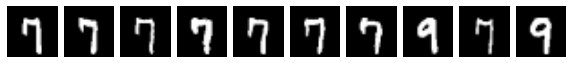

In [74]:
normalized_mnist = mnist.train.images / np.linalg.norm(mnist.train.images, axis=1, keepdims=True)
nns = np.argsort(np.dot(normalized_mnist, mnist.test.images[80]))[::-1][:9] # 9 nearest neighbors to first validation image
res = np.array([mnist.test.images[80]] + [mnist.train.images[i] for i in nns])
plot_mxn(1,10, res)

The first image above is the query, and the next 9 are the nearest neighbors from the training set (in order), measured by cosine distance over the 784-pixel input space.

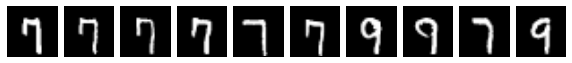

In [75]:
explicit_mnist = []
for i in range(550):
    imgs = sess.run(g['embedding'], feed_dict={g['x']: mnist.train.images[i*100:(i+1)*100], g['stochastic']: False})
    explicit_mnist.append(np.reshape(imgs, (-1, 640)))
explicit_mnist = np.concatenate(explicit_mnist)
normalized_exp_mnist = explicit_mnist / np.linalg.norm(explicit_mnist, axis=1, keepdims=True)
query = np.reshape(sess.run(g['embedding'], feed_dict={g['x']: mnist.test.images[80:81], g['stochastic']: False}), (640,))

nns = np.argsort(np.dot(normalized_exp_mnist, query))[::-1][:9] # 9 nearest neighbors to first validation image
res = np.array([mnist.test.images[80]] + [mnist.train.images[i] for i in nns])
plot_mxn(1,10, res)

The first image above is the query, and the next 9 are the nearest neighbors from the training set (in order), measured by cosine distance over the 640-dimensional explicit embedding space. 

We might also see if we can improve this result by modifying our query vector. Our retrieval will no longer be strict cosine distance, but rather cosine distance-based, like the TF-IDF and MemNN retrieval methods described above.

We adjust our query vector by multiplying each dimension by its "IDF" (the logarithm of the ratio of the number of training samples to the frequency of that dimension in the training set):

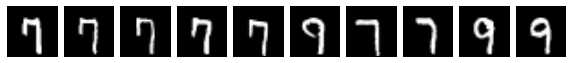

In [76]:
embs =  np.reshape(explicit_mnist, (55000, 80, 8))
IDF_vector = np.log(55000 / (np.reshape(np.sum(embs, axis=0), (640)) + 1))
query = np.reshape(sess.run(g['embedding'], 
                            feed_dict={g['x']: mnist.test.images[80:81], g['stochastic']: False}), 
                   (640,)) * IDF_vector

nns = np.argsort(np.dot(normalized_exp_mnist, query))[::-1][:9] # 9 nearest neighbors to first validation image
res = np.array([mnist.test.images[80]] + [mnist.train.images[i] for i in nns])
plot_mxn(1,10, res)

The first image above is the query, and the next 9 are the nearest neighbors from the training set (in order), measured by the cosine distance between the modified query (query vector * the IDF vector) and the embedding of each training sample. 

The results of our modified query are not clearly better or worse, so the most we can conclude from this demonstration is that adjusting our query by the IDF of each feature did not seem to hurt.

Notice how the practical utility of these nearest neighbors would be similar to the generated samples in the generating by prototype example from Part II. 

#### Retrieval of Individual MNIST Digits by Feature

Now let's do the equivalent of generation based on features, first over the original input space, and then over the explicit embedding space. Take note of how the resulting figures are similar to the figure we produced above when generating samples with these same specific features.

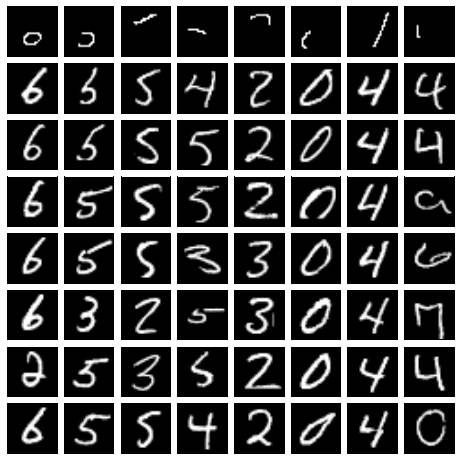

In [77]:
res = [f[0] for f in features]
nns = []
for idx in range(8):
    nns.append(np.argsort(np.dot(normalized_mnist, res[idx]))[::-1][:7])
nns = np.array(nns).T.reshape((56))
for n in nns:
    res.append(mnist.train.images[n])
res = np.array(res)
plot_nxn(8, res)

Retrieval by feature over the original input space.

In [78]:
firing_patterns = []
for feature in range(8):
    noisy_imgs = get_noisy_imgs(features[feature])
    embs = sess.run(g['embedding'], feed_dict={g['x']: noisy_imgs, g['stochastic']: False})
    firing_patterns.append(np.sum(embs, axis=0))
    
feature_embs = np.array(firing_patterns)
feature_embs[feature_embs < 200] = 0. # get rid of the random neurons that were firing
feature_embs = feature_embs*feature_embs # amplify the effect of the neurons that fire most often

feature_embs = np.reshape(feature_embs, (8, 640)) * IDF_vector # adjust the by activation IDFs

res = [f[0] for f in features]
nns = []
for idx in range(8):
    nns.append(np.argsort(np.dot(normalized_exp_mnist, feature_embs[idx]))[::-1][:7])
nns = np.array(nns).T.reshape((56))
for n in nns:
    res.append(mnist.train.images[n])
res = np.array(res)

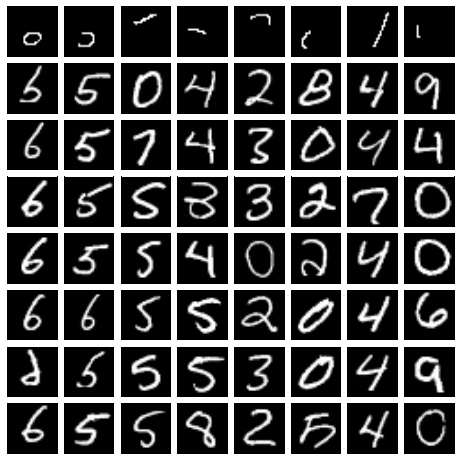

In [79]:
plot_nxn(8, res)

Retrieval by feature over the explicit embedding space.

Now that we have a working memory system, we can use it to demonstrate the interaction of memory and generation. Suppose we want to generate samples from features like we did in Part II. Instead of defining prompts for the features by using noise, we can instead use the activations from the nearest neighbors. This is definition by association (e.g., a unknown word that you can nevertheless guess the meaning of, due to its context). 

We find the 30 nearest neighbors, and subsample their most common activations to define each prompt.

In [80]:
res = [f[0] for f in features]
firing_patterns = []
for idx in range(8):
    nns = np.argsort(np.dot(normalized_mnist, res[idx]))[::-1][:30]
    embs = sess.run(g['embedding'], feed_dict={g['x']: [mnist.train.images[n] for n in nns], g['stochastic']: False})
    firing_patterns.append(np.sum(embs, axis=0))

In [81]:
generated_samples = [] 
for feature in range(8):
    num_common_activations = np.sum(firing_patterns[feature] > 18)
    prompt = np.array(list(range(640)))[np.argsort(np.reshape(firing_patterns[feature], (640)))[::-1][:num_common_activations]]
    nums = np.sort(np.reshape(firing_patterns[feature], (640)))[::-1][:num_common_activations]
    den = np.sum(nums)
    p = nums/den
    generated_samples.append([])
    for sample in range(0, 7):
        emb_idx = generate_embedding(np.random.choice(prompt, size=min(int(num_common_activations*.8), 8), replace=False, p=p), 3)
        emb = emb_idx_to_emb(emb_idx)
        generated_samples[-1].append(emb)
generated_samples = np.squeeze(generated_samples)
generated_samples = np.reshape(np.swapaxes(generated_samples, 0, 1), (56, 80, 8))

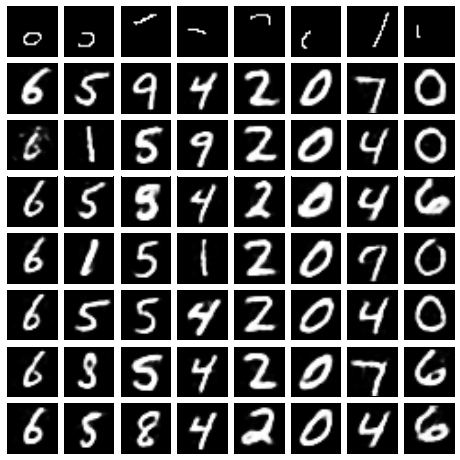

In [82]:
projs = sess.run(g['projection'], feed_dict={g['embedding']: generated_samples, g['stochastic']: False})
plot_nxn(8, np.concatenate((np.squeeze(features), projs)))

This approach to defining prompts seems to provide a bit more stability, and diversity, than the noise-based approach above. 

There are a few key takeaways from the above discussion:

- First, we visually demonstrated the relationship between generation and memory: the outputs are more or less interchangeable (of course, the digits in memory are of superior quality---though as noted in Part II, the generator has a lot of room for improvement). 

- Second, we visually demonstrated the power of cosine distance: we can retrieve entire images based on only a fragment, which provides us with a content-addressable memory. We can now see why MemNN's can work effectively: they only need a small fragment of what they are trying to retrieve from memory in order to retrieve it. The embedding layers that are used before taking the cosine distance can amplify the most relevant parts of the query. 

- Third, using context provided by memory can result in better definitions when facing the general problem of explicit definition. Even so, the definitions used were still brittle, as several of the samples we generated do not match the desired feature at all.

### Enter sequences: where cosine distance fails

Although this post has so far dealt with MNIST, a non-sequential dataset of individual digits, what I'm truly interested in is how we deal with sequences or sets. We've actually already seen two instances of set-based recall:

- The first is the MemNN. If you had been paying close attention to my description of the MemNN above, you may have realized that the basic MemNN architecture I described has no way of answering the sample questions provided. This is because each of the sample questions has a sequential component: Where is the milk **now**? Where is Joe [**now**]? Where was Joe **before the office**? In order for the MemNN to answer questions of this nature, Weston et al. augment the basic architecture  with a mechanism for modeling the time of each memory. Their approach is described in Section 3.4 of [Weston et al. (2015)](https://arxiv.org/abs/1410.3916). Notably, their approach involves iterating over timestamped memories.

- The second is actually feature-based generation and retrieval. If we view each MNIST digit as a sum of its features, then we are actually retrieving a set from a subset thereof. 

The recall of sequences and sets is critical for agents that experience time (e.g., RNNs), and also has many practical applications (the most notable being plain old text-based search, where we recall documents based on their words (features)). We've seen how cosine distance-based search can be extremely effective for set retrieval, if we have a vector that represents the entire set. 

Cosine distance can also be effective for sequence retrieval, _if we have a vector that represents the sequence_. For example, the vectors used by the MemNN as memories and inputs are precisely this: vectors representing an entire sentence (sequence of words). For cosine distance to work on sequences, we not only need a vector that represents the sequence, but it must also represent the temporal features of the sequence that we are interested in (if any). The MemNN sequence vectors use a bag of words model and do not contain any temporal features.

Consider the following toy retrieval tasks: 

If we were to write out the entire MNIST training sequence, 

- are there any instances of the consecutive digits "5134" in the sequence, and if so, where?
- how many times does the digit "6" appear with four digits of the digit "3"? 
- are there any strings of ten digits that contain all features in some given set of sub-digit features? 

For an agent that works only with vector-based memories and cosine distance-based retrieval, all three are quite difficult. 

If we index each digit as a separate memories, all involve multiple queries. For example, in the first instance we would have to (1) retrieve the positions of _all_ 5s in memory, and (2) filter out the 5s that are not followed by a 1 and a 3, which requires us to either retrieve the positions of all 1s and 3s, or examine the digits following each 5. The second and third tasks are even more difficult. 

If instead we index sequences of digits, we run into a few problems: 

- How do we represent sequences in memory? Bag of words (adding individual vectors) might work for problems that ignore order and temporal structure, but will fail for any problem that does not. Use a sequence autoencoder is one solution, but it is fraught with ambiguity and may not contain the necessary information to properly execute the query. How could we design a sequence vector that contains the information required for the second and third tasks above, in addition to other such questions? 
- How do we represent the query as a vector? We already ran into some trouble with this in Part II when trying to represent small features as entire vectors of explicit embeddings: we ended up simulating a bunch of noisy sets and then finding the most important activations across all simulations. This did OK, but was unprincipled and had lackluster results. 
- What length of sequence do we want to index? It is impractical to index all sequence lengths, so we need to make an _ex ante_ choice. This runs counter to our idea of search as _ex post_ classification. 

I consider these problems prohibitive, so let us table cosine distance, and instead take a look at what I call **structured information retrieval**, which, with a little bit of work, we can make work with our explicit embeddings. 

### Structured information retrieval

When you do a phrase search on Google, i.e., a search with "double quotes", you are doing structured information retrieval. Cosine distance is still in the picture, but it is no longer the critical ingredient: phrase search requires us to first identity all documents that contain the phrase. Recall that query terms are stored in an inverted index together with their postings. The phrase search algorithm operates on the postings list and find all instances of a phrase, without ever needing to retrieve an entire document. You can see the details of the phrase search algorithm in Section 2.1.1 of Büttcher et al. (which is in one of the free sample chapters provided online). 

Phrase search is just one example of a more general class of constraint-based queries that define a structure on a set of terms. Within this class of queries, we can include Boolean search, passage retrieval, and more general query languages that allow users to define lightweight structure such as "find sentences containing terms X and Y" or the third task above (see Section 5.2 of Büttcher et al. for a detailed discussion). 

Structured information retrieval cannot be done with cosine distance: it requires access to the postings list of each query term. With real-valued embeddings, there is no principled way to create such an index (or at least, none that I could think of). With one-hot embeddings, however, we have some additional flexibility.

Below we will take a simple approach to information retrieval over the sequence of the MNIST training images. In particular, we will show how explicit embeddings allow us to solve the following problem:

Does the ordered sequence of MNIST training images (55000 images) contain any subsequences of four consecutive digits that have the following four features, respectively, and if so, where:

<img src='images/feature_query.png' />

### Indexing one-hot features

To begin, we need to build our index, which is a dictionary mapping features to a _positions_ vector. We will treat each dimension of our explicit embedding as a feature (so that there are 640 total features), and we will index the entire MNIST training sequence in order. We also define a functions to find the intersection and union of postings lists, which will allow us to compose postings lists to create postings lists for features.

In [83]:
embs = explicit_mnist.T
postings = [None] * 640
for i, positions in enumerate(embs):
    postings[i] = np.squeeze(np.argwhere(positions))

In [84]:
from itertools import chain

In [85]:
def ipostings(idx_list):
    """Gets the intersection of postings for the activations in idx_list"""
    res = postings[idx_list[0]]
    for i in range(1, len(idx_list)):
        res = list(intersect_sorted(res, postings[idx_list[i]]))
    return np.array(res)


def upostings(list_of_postings):
    """Gets the union of postings"""
    return np.array(sorted(set(chain.from_iterable(list_of_postings))))

In [86]:
# positions where the activation 1 is hot
postings[1] 

array([    4,     6,    18, ..., 54972, 54974, 54980])

In [87]:
# positions where activations 1 and 10 co-occur
ipostings([1, 10]) 

array([   32,    84,    95, ..., 54680, 54702, 54966])

In [88]:
# positions where activations 1 and 5 co-occur (empty, because they are from the same neuron)
ipostings([1, 5]) 

array([], dtype=float64)

In [89]:
# positions where activation 1 co-occurs with any of the activations 10, 15, or 23
upostings((ipostings([1, 10]), ipostings([1, 15]), ipostings([1, 23]))) 

array([   18,    32,    38, ..., 54972, 54974, 54980])

#### Finding consecutive features

To find subsequences with the desired features, we first identify what those feature are, and then run a phrase search using their postings list. We obtain the feature posting lists by (1) finding the posting list for each group of three activations in the five most common activations for that features, (2) taking their union. 

Our definition of the features is extremely brittle. Here we have even less flexibility than we did when retrieving nearest neighbors or generating samples because we need to use exact definitions. Our process is far from perfect: we use the noise-based approach to produce firing patterns, and then define the feature to be any instance where any combination of 4 such common activations fire together. This no doubt misses a lot of digits that do contain the feature being queries, but trial and error shows that using less than the intersection of 4 common activations produces very noisy results (we obtain a lot of matches that do not contain the feature). 

In [106]:
firing_patterns = []
for feature in range(8):
    noisy_imgs = get_noisy_imgs(features[feature])
    embs = sess.run(g['embedding'], feed_dict={g['x']: noisy_imgs, g['stochastic']: False})
    firing_patterns.append(np.sum(embs, axis=0))

In [107]:
F1, F2, F3 = 1, 3, 6 # the indices of the features that make up our query

In [108]:
from itertools import combinations

In [109]:
# Get the common activations
neuron_lists = []
for feature in [F1, F2, F3]: 
    num_common_activations = np.sum(firing_patterns[feature] > 260)
    firing_pattern = np.reshape(firing_patterns[feature], (640)).astype(np.int32)
    neuron_lists.append(np.array(list(range(640)))[np.argsort(firing_pattern)[::-1][:min(10, num_common_activations)]])

print(neuron_lists)
# Get intersected postings for each combination of 3 activations in the most common
combo_lists = [list(map(ipostings, combinations(l, max(len(l) - 4, 4)))) for l in neuron_lists]
# Get the union of the above for each feature
positions = list(map(upostings, combo_lists))
[len(p) for p in positions]

[array([ 33, 140, 277, 209, 301, 188, 547,  68, 174, 195]), array([201, 298, 215, 541, 421, 523, 343, 311,  68, 174]), array([292,  66, 265, 330, 637, 613, 499,  26,  33, 542])]


[237, 524, 1265]

In [115]:
"""Because our data is small, we take a naive approach to phrase search. 
A more efficient algorithm is presented in Section 2.1.1 of Büttcher et al."""

res12 = [np.concatenate([features[F1], features[F2]])]
res123 = [np.concatenate([features[F1], features[F2], features[F3]])]
for p in positions[0]:
    if p+1 in positions[1]:
        if p+2 in positions[2]:
            print("Full phrase match found in positions", p, "to", p+2)
            res123.append(mnist.train.images[p:p+3])
        res12.append(mnist.train.images[p:p+2])
        print("Partial phrase match of 1st and 2nd query elements found in positions", p, "to", p+1)

res23 = [np.concatenate([features[F2], features[F3]])]
for p in positions[1]:
    if p+1 in positions[2]:
        res23.append(mnist.train.images[p:p+2])
        print("Partial phrase match of 2nd and 3rd query elements found in positions", p, "to", p+1)

Partial phrase match of 1st and 2nd query elements found in positions 1151 to 1152
Partial phrase match of 1st and 2nd query elements found in positions 39054 to 39055
Partial phrase match of 2nd and 3rd query elements found in positions 14294 to 14295
Partial phrase match of 2nd and 3rd query elements found in positions 14436 to 14437
Partial phrase match of 2nd and 3rd query elements found in positions 17310 to 17311
Partial phrase match of 2nd and 3rd query elements found in positions 20984 to 20985
Partial phrase match of 2nd and 3rd query elements found in positions 21198 to 21199
Partial phrase match of 2nd and 3rd query elements found in positions 27052 to 27053
Partial phrase match of 2nd and 3rd query elements found in positions 28786 to 28787
Partial phrase match of 2nd and 3rd query elements found in positions 45352 to 45353
Partial phrase match of 2nd and 3rd query elements found in positions 47446 to 47447
Partial phrase match of 2nd and 3rd query elements found in positio

### Matches

Our approach found no matches for three consecutive features. We did, however, find matches for each pair of consecutive features. 

Note that this suffers from the same explicit definition problem as our feature-based generation and feature-based recall: our internal representation of each feature is not perfect, and there is no perfect approach to obtaining such an internal representation.

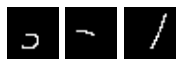

In [111]:
# There are no matches for all three features
plot_mxn(len(res123), 3, np.concatenate(res123))

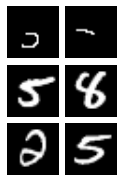

In [112]:
# There are 2 matches for the first and second features
plot_mxn(len(res12), 2, np.concatenate(res12))

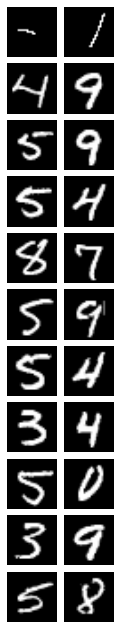

In [113]:
# There are several matches for the second and third features
plot_mxn(len(res23), 2, np.concatenate(res23))

## Further work

In this post, we played with explicit embeddings and saw that they can be used in much the same way as language. We also ran into several problems as a result of the basic challenge of language, which is semantic ambiguity: what's in a definition? As a result of this challenge, I do not think the approach presented in this post is practical in its current form. Nevertheless, I think this is a good direction to be thinking about as we try to make progress toward to Stage III architectures. 

Some of the questions I'm interested in working on going forward are:

- MNIST is perhaps too simple; are the various tasks we carried out (generation and memory) using explicit embeddings practical for more complex datasets? 
- Is there a way to create smaller explicit embeddings, where each activation is more meaningful, so that feature definitions will be easier?
- Is there a useful distribution that we could enforce on explicit embeddings to make feature definitions easier to work with? Is there someway to enforce, e.g., [Zipf's law](https://en.wikipedia.org/wiki/Zipf's_law) on the definitions of certain landmark features? 
- Is there a general method for constructing feature definitions in terms of an explicit embedding that work well to other use cases?
- One of the key motivations behind the use of a symbolic language is communication. But here, all symbols were created intra-agent: they have meaning only within the agent's mind (we constructed symbolic definitions of our features by feeding the agent real-valued vectors). How can we define a useful inter-agent model instead?
- How do the methods here relate to GANs and VAEs? Can they be combined in a useful way? 
- Is there a good way to define a feature discriminator (i.e., to decide whether something is an instance of a feature or not (remember, it has only 1 sample)). 
- Indexing discrete features requires that representations remain static. Is there a good way to reindex past features so that we can overcome this limitation?
- Is there a way we can take advantage of the distribution of the softmax activations in the embedding layer (before we turn it into a one-hot vector)? For instance, to give us a measure of our network's confidence in its final predictions, or the quality of the explicit embeddings? 

And also two specific questions about particular architectures:

- Would adding an external generator to the MemNN increase the range of tasks it can solve? (E.g, to QA about hypothetical scenarios).
- Can we create explicit embeddings of word vectors that behave like word2vec, and perhaps offer some advantages? cf. [Faruqui et al. (2015)](https://arxiv.org/abs/1506.02004).